In [1]:
import os
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import  Counter
from tqdm import tqdm
%matplotlib inline

#### Analiza będzie przeprowadzona na traksrypcie z kultowego serialu The Office. Jest to serial komediowo-dokumentalny tzw. "mockumentary", pokazujący codzienność w oddziale firmy papierniczej w Scranton. Główna postać - Michael, w rolę którego wciela się Steve Carell jest managerem oddziału. Serial stworzony przez Rickiego Gervais'a - brytyjskiego reżysera, scenarzysty oraz aktora komediowego.

#### Przeprowadzona zostanie eksploracja danych oraz próba zamodelowania przypisania prawidłowo wypowiedzi do postaci, która dany tekst wypowiedziała.

### Ściągamy dane dotyczące wypowiedzi postaci z serialu The Office

In [2]:
office_data = pd.read_csv('./office_text.csv')

In [3]:
office_data

,Unnamed: 0,index,season,episode,episode_name,director,writer,character,text,text_w_direction,imdb_rating,total_votes,air_date
0,1,1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...,7.6,3706,2005-03-24
1,2,2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So...",7.6,3706,2005-03-24
2,3,3,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,So you've come to the master for guidance? Is ...,So you've come to the master for guidance? Is ...,7.6,3706,2005-03-24
3,4,4,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.",7.6,3706,2005-03-24
4,5,5,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done.",7.6,3706,2005-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55125,55126,55126,9,24,Finale,Ken Kwapis,Greg Daniels,Jim,Athleap.,Athleap.,9.7,7934,2013-05-16
55126,55127,55127,9,24,Finale,Ken Kwapis,Greg Daniels,Dwight,Why did you pick this place?,[to Mose] Why did you pick this place? [Mose p...,9.7,7934,2013-05-16
55127,55128,55128,9,24,Finale,Ken Kwapis,Greg Daniels,Pam,And Jim can jump back in without skipping a be...,And Jim can jump back in without skipping a be...,9.7,7934,2013-05-16
55128,55129,55129,9,24,Finale,Ken Kwapis,Greg Daniels,Jim,Ooh.,Ooh.,9.7,7934,2013-05-16


In [4]:
office = office_data[['index', 'season', 'episode', 'episode_name', 'character', 'text', 'text_w_direction', 'imdb_rating']].dropna()

In [5]:
def clean_character(data):
    def f(c):
        c = str(c)
        out = c.strip('". ')
        return out
    data['character'] = data['character'].map(f).str.title()
    data['character'] = data['character'].str.replace("'S", "'s")
    # clean specific characters
    ch = data['character']
    data.loc[ch.str.contains('Hele'),'character'] = 'Helene'
    data.loc[ch.str.contains('Pam.s Mom'),'character'] = 'Helene'
    for misspell in 'Anglea Angels'.split():
        data.loc[ch == misspell, 'character'] = 'Angela'
    data.loc[ch.str.contains('Bob Vance'), 'character'] = 'Bob Vance'
    data.loc[ch == 'Cameraman', 'character'] = 'Camera Man'
    data.loc[ch == 'Chares', 'character'] = 'Charles'
    for misspell in 'Dacvid Wallcve'.split():
        data.loc[ch.str.contains(misspell), 'character'] = 'David Wallace'
    for misspell in 'Darrly Darry Daryl'.split():
        data.loc[ch == misspell, 'character'] = 'Darryl'
    data.loc[ch == 'Glen', 'character'] = 'Glenn'
    data.loc[ch.str.contains('^Hank'), 'character'] = 'Hank'
    data.loc[ch == 'Holy', 'character']  = 'Holly'
    data.loc[ch == 'M Ichael', 'character'] = 'Michael'
    data.loc[ch == 'Jo', 'character'] = 'Jo Bennett'
    data.loc[ch.str.contains('Phylis'), 'character'] = 'Phyllis'
    data.loc[ch == 'Rolf', 'character'] = 'Rolph'
    # normalize 'and' notation
    for and_spelling in [' ?& ?', ' ?/ ?', ' And ']:
        data['character'] = data['character'].str.replace(and_spelling, ' and ')

In [6]:
clean_character(office)
office.head

C:\Users\domin\AppData\Local\Temp\ipykernel_13396\1675338809.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  data['character'] = data['character'].str.replace(and_spelling, ' and ')


<bound method NDFrame.head of        index  season  episode episode_name character  \
0          1       1        1        Pilot   Michael   
1          2       1        1        Pilot       Jim   
2          3       1        1        Pilot   Michael   
3          4       1        1        Pilot       Jim   
4          5       1        1        Pilot   Michael   
...      ...     ...      ...          ...       ...   
55125  55126       9       24       Finale       Jim   
55126  55127       9       24       Finale    Dwight   
55127  55128       9       24       Finale       Pam   
55128  55129       9       24       Finale       Jim   
55129  55130       9       24       Finale    Dwight   

                                                    text  \
0      All right Jim. Your quarterlies look very good...   
1             Oh, I told you. I couldn't close it. So...   
2      So you've come to the master for guidance? Is ...   
3             Actually, you called me in here, but yeah. 

Standardowa szerokość kolumn: 50 znaków


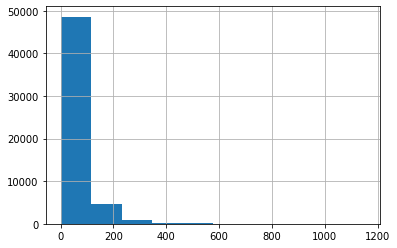

In [7]:
office['text'].str.len().hist()
print(f"Standardowa szerokość kolumn: {pd.get_option('display.max_colwidth')} znaków")

In [8]:
pd.set_option('display.max_colwidth', 500)
office.head(10)

,index,season,episode,episode_name,character,text,text_w_direction,imdb_rating
0,1,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good. How are things at the library?,All right Jim. Your quarterlies look very good. How are things at the library?,7.6
1,2,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So...",7.6
2,3,1,1,Pilot,Michael,"So you've come to the master for guidance? Is this what you're saying, grasshopper?","So you've come to the master for guidance? Is this what you're saying, grasshopper?",7.6
3,4,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.",7.6
4,5,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done.",7.6
5,6,1,1,Pilot,Michael,"Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wanted to talk to you manager-a-manger. All right. Done deal. Thank you very much, sir. You're a gentleman and a scholar. Oh, I'm sorry. OK. I'm sorry. My mistake. That was a woman I was talking to, so... She had a very low voice. Probably a smoker, so... So that's the way it's done.","[on the phone] Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wanted to talk to you manager-a-manger. [quick cut scene] All right. Done deal. Thank you very much, sir. You're a gentleman and a scholar. Oh, I'm sorry. OK. I'm sorry. My mistake. [hangs up] That was a woman I was talking to, so... She had a very low voice. Probably a smoker, so... [Clears throat] So that's the way it's done.",7.6
6,7,1,1,Pilot,Michael,"I've, uh, I've been at Dunder Mifflin for 12 years, the last four as Regional Manager. If you want to come through here... See we have the entire floor. So this is my kingdom, as far as the eye can see. This is our receptionist, Pam. Pam! Pam-Pam! Pam Beesly. Pam has been with us for... forever. Right, Pam?","I've, uh, I've been at Dunder Mifflin for 12 years, the last four as Regional Manager. If you want to come through here... See we have the entire floor. So this is my kingdom, as far as the eye can see. This is our receptionist, Pam. Pam! Pam-Pam! Pam Beesly. Pam has been with us for... forever. Right, Pam?",7.6
7,8,1,1,Pilot,Pam,Well. I don't know.,Well. I don't know.,7.6
8,9,1,1,Pilot,Michael,"If you think she's cute now, you should have seen her a couple of years ago.","If you think she's cute now, you should have seen her a couple of years ago. [growls]",7.6
9,10,1,1,Pilot,Pam,What?,What?,7.6


#### Zamieniamy nasz tekst na słowa

In [9]:
corpus = []
for x in office['text'].str.split(' '):
    corpus.extend(x)   

#### Znajdujemy najczęstsze słowa

In [10]:
counter=Counter(corpus) #przechodzi przez listę i liczy wystąpienia wszystkich słów
most=counter.most_common()
print(most[0:10])

[('I', 20110), ('the', 13269), ('to', 13036), ('you', 13007), ('a', 12257), ('is', 6294), ('of', 6130), ('and', 6044), ('that', 5240), ('in', 4679)]


25 najczęściej występujących słów


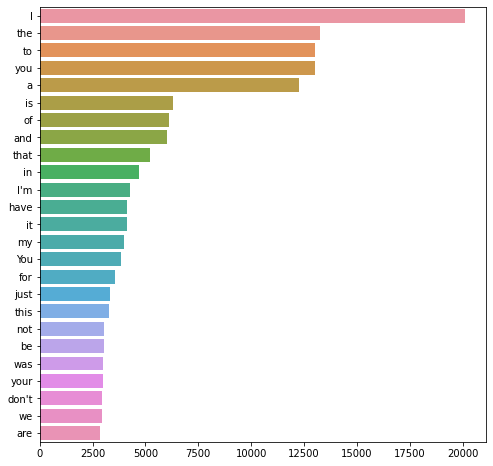

In [11]:
first_n = 25
x, y= [], []
for word,count in most[:first_n]:
        x.append(word)
        y.append(count)

plt.figure(figsize=(8, 8))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących słów")       

#### Znajdziemy najczęstsze słowa z pominięciem stopwords

In [12]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


25 najczęściej występujących slów w korpusie


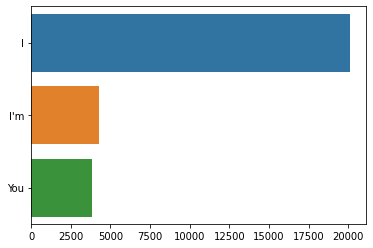

In [13]:
first_n = 25
x, y= [], []
for word,count in most[:first_n]:
    if word not in stop:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")       

In [14]:
most_nostop = []
for word, count in most:
    if word.lower() not in stop:
        most_nostop.append((word, count))

25 najczęściej występujących slów w korpusie


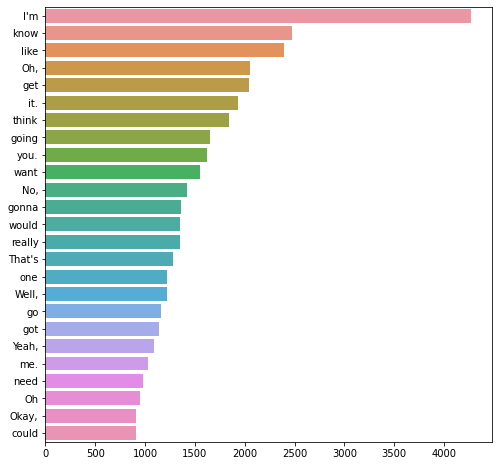

In [15]:
first_n = 25
x, y= [], []
for word,count in most_nostop[:first_n]:
        x.append(word)
        y.append(count)

plt.figure(figsize=(8, 8))
sns.barplot(x=y,y=x)
print(f"{first_n} najczęściej występujących slów w korpusie")

### Tokenizacja

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize
example = office["text"][0]
print(example)
print("\n")
print("Tokenizacja na słowa:")
print(word_tokenize(example))

print("\n")
print("Tokenizacja na zdania (pierwsze 2 zdania):")
for sent in sent_tokenize(example)[0:2]:
    print(sent)

All right Jim. Your quarterlies look very good. How are things at the library?


Tokenizacja na słowa:
['All', 'right', 'Jim', '.', 'Your', 'quarterlies', 'look', 'very', 'good', '.', 'How', 'are', 'things', 'at', 'the', 'library', '?']


Tokenizacja na zdania (pierwsze 2 zdania):
All right Jim.
Your quarterlies look very good.


In [17]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [18]:
office["text_cleaned"] = office["text"].apply(preprocessor)
office["text_cleaned"].head()

0         all right jim your quarterlies look very good how are things at the library 
1                                                oh i told you i couldn t close it so 
2    so you ve come to the master for guidance is this what you re saying grasshopper 
3                                             actually you called me in here but yeah 
4                                        all right well let me show you how it s done 
Name: text_cleaned, dtype: object

In [19]:
tqdm.pandas()
office["text_tokenised"] = office['text_cleaned'].dropna().progress_apply(word_tokenize)

100%|██████████| 54756/54756 [00:04<00:00, 12601.12it/s]


In [20]:
office["text_tokenised"].head()

0           [all, right, jim, your, quarterlies, look, very, good, how, are, things, at, the, library]
1                                                      [oh, i, told, you, i, couldn, t, close, it, so]
2    [so, you, ve, come, to, the, master, for, guidance, is, this, what, you, re, saying, grasshopper]
3                                                     [actually, you, called, me, in, here, but, yeah]
4                                             [all, right, well, let, me, show, you, how, it, s, done]
Name: text_tokenised, dtype: object

In [21]:
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import accuracy_score
import numpy as np

In [22]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [23]:
def tokenizer_porter(tokens):
    return [porter.stem(token) for token in tokens]

In [24]:
office["text_stem"] = office["text_tokenised"].progress_apply(tokenizer_porter)
office["text_stem"].head()

100%|██████████| 54756/54756 [00:08<00:00, 6679.86it/s]


0       [all, right, jim, your, quarterli, look, veri, good, how, are, thing, at, the, librari]
1                                               [oh, i, told, you, i, couldn, t, close, it, so]
2    [so, you, ve, come, to, the, master, for, guidanc, is, thi, what, you, re, say, grasshopp]
3                                                  [actual, you, call, me, in, here, but, yeah]
4                                      [all, right, well, let, me, show, you, how, it, s, done]
Name: text_stem, dtype: object

### Wyeliminujemy najrzadziej pojawiające się postacie

In [25]:
all_characters = office.groupby('character').count()[['index']].sort_values('index', ascending=False).index.values
main_characters = all_characters[:20]
main_characters

array(['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Angela', 'Kevin',
       'Erin', 'Oscar', 'Darryl', 'Ryan', 'Phyllis', 'Kelly', 'Toby',
       'Jan', 'Stanley', 'Meredith', 'Holly', 'Nellie', 'Gabe'],
      dtype=object)

In [26]:
office_best = office.character.isin(main_characters)
office_filtered = office[office_best]
office_filtered.head()

,index,season,episode,episode_name,character,text,text_w_direction,imdb_rating,text_cleaned,text_tokenised,text_stem
0,1,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good. How are things at the library?,All right Jim. Your quarterlies look very good. How are things at the library?,7.6,all right jim your quarterlies look very good how are things at the library,"[all, right, jim, your, quarterlies, look, very, good, how, are, things, at, the, library]","[all, right, jim, your, quarterli, look, veri, good, how, are, thing, at, the, librari]"
1,2,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So...",7.6,oh i told you i couldn t close it so,"[oh, i, told, you, i, couldn, t, close, it, so]","[oh, i, told, you, i, couldn, t, close, it, so]"
2,3,1,1,Pilot,Michael,"So you've come to the master for guidance? Is this what you're saying, grasshopper?","So you've come to the master for guidance? Is this what you're saying, grasshopper?",7.6,so you ve come to the master for guidance is this what you re saying grasshopper,"[so, you, ve, come, to, the, master, for, guidance, is, this, what, you, re, saying, grasshopper]","[so, you, ve, come, to, the, master, for, guidanc, is, thi, what, you, re, say, grasshopp]"
3,4,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.",7.6,actually you called me in here but yeah,"[actually, you, called, me, in, here, but, yeah]","[actual, you, call, me, in, here, but, yeah]"
4,5,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done.",7.6,all right well let me show you how it s done,"[all, right, well, let, me, show, you, how, it, s, done]","[all, right, well, let, me, show, you, how, it, s, done]"


### Poszukamy podobieństw w wypowiedziach

In [27]:
office_sents = list(map(list, office_filtered['text_tokenised'].values))

In [28]:
pip install -U gensim

In [29]:
import gensim
%time wv = gensim.models.Word2Vec([s for s in office_sents if len(s) > 5], vector_size=50, min_count=5, workers = 3)

CPU times: total: 2.66 s
Wall time: 1.05 s


In [30]:
def most_similar(wv, words, *a, **kw):
    words = list(np.atleast_1d(words))
    words = [w for w in words if w in wv.wv]
    return wv.wv.most_similar(words, *a, **kw)

def get_vec(wv, words, *a, **kw):
    words = np.atleast_1d(words)
    words = [w for w in words if w in wv.wv]
    return np.mean([wv.wv[w] for w in words], axis=0)

In [31]:
from sklearn.metrics import pairwise

def get_vecs(columns, data=office_filtered, wv=wv, only=None):
    gb = data.groupby(columns)
    vecs = {
        key: get_vec(wv, np.concatenate(d['text_tokenised'].values))
        for (key, d) in gb
        if only is None or key in only
    }
    return vecs

def get_similarity(vecs, pivot=True):
    #vecs = get_vecs(columns, data=data, wv=wv, only=only)
    k1s, k2s, similaritys = [], [], []
    for k1 in vecs:
        for k2 in vecs:
            k1s.append(k1)
            k2s.append(k2)
            similaritys.append(1 - pairwise.euclidean_distances([vecs[k1]], [vecs[k2]])[0][0])
    similarity = pd.DataFrame(dict(k1=k1s, k2=k2s, s=similaritys))
    if pivot:
        similarity = similarity.pivot('k1', 'k2', 's')
    return similarity

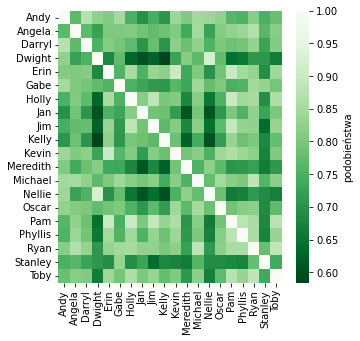

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
hmap = sns.heatmap(get_similarity(get_vecs('character', only=main_characters)), cmap='Greens_r', cbar_kws=dict(label='podobieństwa'))
hmap.set_xlabel(''), hmap.set_ylabel('');

#### Z wykresu odczytujemy, że niektórzy mają pdobny styl mówienia

In [34]:
X_data = office_filtered["text_stem"].copy()
y_data = office_filtered["character"].copy()

In [35]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=random_state)
train_idx = X_train.index.tolist()
test_idx = X_test.index.tolist()

### N-gramy

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=5, top_ngrams=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_ngrams]

In [37]:
bigrams = get_top_ngram(office_filtered["text"])

<AxesSubplot:>

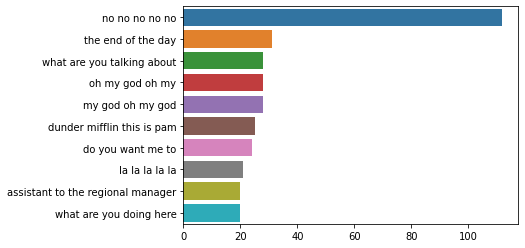

In [38]:
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x) #widać, że trzeba by oczyścić dane

### Przejdziemy teraz do próby zamodelowania rozpoznawania postaci mówiącej.

### Trenowanie modelu opartego o reprezentację BoW

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
def do_nothing(tokens):
    return tokens

bow_count = CountVectorizer(tokenizer=do_nothing,
                             preprocessor=None,
                             lowercase=False)

In [41]:
X_train_bow_count = bow_count.fit_transform(X_train)
X_test_bow_count = bow_count.transform(X_test)

In [42]:
clf = MultinomialNB()
clf.fit(X_train_bow_count, y_train)

MultinomialNB()

In [43]:
y_train_pred = clf.predict(X_train_bow_count)
y_test_pred = clf.predict(X_test_bow_count)
multiNB_bow_train_score = accuracy_score(y_train, y_train_pred)
multiNB_bow_test_score = accuracy_score(y_test, y_test_pred)
print(f"multiNB_bow_score na zbiorze treningowym: {multiNB_bow_train_score}")
print(f"multiNB_bow_score na zbiorze testowym: {multiNB_bow_test_score}")

multiNB_bow_score na zbiorze treningowym: 0.3589533932951758
multiNB_bow_score na zbiorze testowym: 0.2671707179197287


In [44]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        Andy       0.33      0.08      0.13      1138
      Angela       0.58      0.02      0.03       462
      Darryl       0.11      0.00      0.01       350
      Dwight       0.35      0.24      0.29      2081
        Erin       0.33      0.03      0.05       437
        Gabe       0.33      0.01      0.02       126
       Holly       0.00      0.00      0.00       160
         Jan       0.00      0.00      0.00       237
         Jim       0.24      0.20      0.21      1884
       Kelly       0.00      0.00      0.00       250
       Kevin       0.15      0.01      0.01       481
    Meredith       0.00      0.00      0.00       170
     Michael       0.26      0.82      0.40      3206
      Nellie       0.00      0.00      0.00       158
       Oscar       0.27      0.01      0.01       407
         Pam       0.23      0.09      0.13      1523
     Phyllis       0.00      0.00      0.00       283
        Ryan       0.00    

C:\Users\domin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\domin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\domin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Regresja logistyczna

In [73]:
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [74]:
random_state = 42
data_train, data_test = train_test_split(office_filtered, test_size=0.30, random_state=random_state)

In [75]:
def simple_cleaning(text):
    cleaned = []
    tokenised = word_tokenize(text)
    for token in tokenised:
        cl_token = re.sub("\W|_", "", token).lower()
        if len(cl_token) > 0:
            cleaned.append(cl_token)
    doc = " ".join(cleaned)
    return doc if len(doc) > 0 else np.nan

In [76]:
data_train["text_clean"] = list(map(lambda x: simple_cleaning(x), tqdm(data_train["text"])))
data_test["text_clean"] = list(map(lambda x: simple_cleaning(x), tqdm(data_test["text"])))

100%|██████████| 14152/14152 [00:01<00:00, 7689.47it/s]


In [77]:
tf_vectorizer = TfidfVectorizer()
X_train_tf = tf_vectorizer.fit_transform(data_train["text"])
X_test_tf = tf_vectorizer.transform(data_test["text"])

clf = LogisticRegression(random_state=0, C=10, max_iter = 1500)

In [78]:
y_train = data_train["character"]
y_test = data_test["character"]

In [79]:
%%time
clf.fit(X_train_tf, y_train)

CPU times: user 2min 49s, sys: 35.9 s, total: 3min 25s
Wall time: 27.1 s


LogisticRegression(C=10, max_iter=1500, random_state=0)

In [80]:
print(f"Accuracy na zbiorze treningowym {accuracy_score(y_train, clf.predict(X_train_tf))}")
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))

Accuracy na zbiorze treningowym 0.5895339329517579
              precision    recall  f1-score   support

        Andy       0.23      0.14      0.18      1138
      Angela       0.16      0.08      0.10       462
      Darryl       0.23      0.10      0.14       350
      Dwight       0.29      0.31      0.30      2081
        Erin       0.16      0.07      0.10       437
        Gabe       0.15      0.02      0.04       126
       Holly       0.15      0.04      0.07       160
         Jan       0.18      0.08      0.11       237
         Jim       0.22      0.28      0.25      1884
       Kelly       0.06      0.02      0.03       250
       Kevin       0.12      0.05      0.07       481
    Meredith       0.06      0.01      0.02       170
     Michael       0.31      0.56      0.40      3206
      Nellie       0.13      0.01      0.02       158
       Oscar       0.18      0.06      0.09       407
         Pam       0.20      0.20      0.20      1523
     Phyllis       0.10      0

### Ograniczymy liczbę postaci do 5 wybranych

In [86]:
office_best2 = office.character.isin(['Michael', 'Jim', 'Dwight', 'Stanley', 'Pam'])
office_filtered2 = office[office_best2]
office_filtered.head()

,index,episode,episode_name,character,text,text_w_direction,text_cleaned,text_tokenised,text_stem
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good. How are things at the library?,All right Jim. Your quarterlies look very good. How are things at the library?,all right jim your quarterlies look very good how are things at the library,"[all, right, jim, your, quarterlies, look, very, good, how, are, things, at, the, library]","[all, right, jim, your, quarterli, look, veri, good, how, are, thing, at, the, librari]"
1,2,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So...",oh i told you i couldn t close it so,"[oh, i, told, you, i, couldn, t, close, it, so]","[oh, i, told, you, i, couldn, t, close, it, so]"
2,3,1,Pilot,Michael,"So you've come to the master for guidance? Is this what you're saying, grasshopper?","So you've come to the master for guidance? Is this what you're saying, grasshopper?",so you ve come to the master for guidance is this what you re saying grasshopper,"[so, you, ve, come, to, the, master, for, guidance, is, this, what, you, re, saying, grasshopper]","[so, you, ve, come, to, the, master, for, guidanc, is, thi, what, you, re, say, grasshopp]"
3,4,1,Pilot,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah.",actually you called me in here but yeah,"[actually, you, called, me, in, here, but, yeah]","[actual, you, call, me, in, here, but, yeah]"
4,5,1,Pilot,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done.",all right well let me show you how it s done,"[all, right, well, let, me, show, you, how, it, s, done]","[all, right, well, let, me, show, you, how, it, s, done]"


#### BoW

In [87]:
X_data2 = office_filtered2["text_stem"].copy()
y_data2 = office_filtered2["character"].copy()

In [88]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2, test_size=0.20, random_state=random_state)
train_idx = X_train.index.tolist()
test_idx = X_test.index.tolist()

In [89]:
X_train_bow_count2 = bow_count.fit_transform(X_train)
X_test_bow_count2 = bow_count.transform(X_test)

In [90]:
clf = MultinomialNB()
clf.fit(X_train_bow_count2, y_train)

MultinomialNB()

In [91]:
y_train_pred = clf.predict(X_train_bow_count2)
y_test_pred = clf.predict(X_test_bow_count2)
multiNB_bow_train_score = accuracy_score(y_train, y_train_pred)
multiNB_bow_test_score = accuracy_score(y_test, y_test_pred)
print(f"multiNB_bow_score na zbiorze treningowym: {multiNB_bow_train_score}")
print(f"multiNB_bow_score na zbiorze testowym: {multiNB_bow_test_score}")

multiNB_bow_score na zbiorze treningowym: 0.5307912940779483
multiNB_bow_score na zbiorze testowym: 0.4168353576248313


In [92]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      Dwight       0.48      0.26      0.34      1349
         Jim       0.33      0.21      0.25      1256
     Michael       0.43      0.79      0.55      2183
         Pam       0.35      0.13      0.19      1015
     Stanley       0.10      0.01      0.01       125

    accuracy                           0.42      5928
   macro avg       0.34      0.28      0.27      5928
weighted avg       0.40      0.42      0.37      5928



#### Regresja logistyczna

In [94]:
random_state = 42
data_train, data_test = train_test_split(office_filtered2, test_size=0.20, random_state=random_state)

In [95]:
data_train["text_clean"] = list(map(lambda x: simple_cleaning(x), tqdm(data_train["text"])))
data_test["text_clean"] = list(map(lambda x: simple_cleaning(x), tqdm(data_test["text"])))

100%|██████████| 5928/5928 [00:00<00:00, 7334.01it/s]


In [96]:
tf_vectorizer = TfidfVectorizer()
X_train_tf = tf_vectorizer.fit_transform(data_train["text"])
X_test_tf = tf_vectorizer.transform(data_test["text"])

clf = LogisticRegression(random_state=0, C=10, max_iter = 1000)

In [97]:
y_train = data_train["character"]
y_test = data_test["character"]

In [98]:
%%time
clf.fit(X_train_tf, y_train)

CPU times: user 42.2 s, sys: 10.5 s, total: 52.6 s
Wall time: 7.34 s


LogisticRegression(C=10, max_iter=1000, random_state=0)

In [99]:
print(f"Accuracy na zbiorze treningowym {accuracy_score(y_train, clf.predict(X_train_tf))}")
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))

Accuracy na zbiorze treningowym 0.6836932680951577
              precision    recall  f1-score   support

      Dwight       0.40      0.35      0.38      1349
         Jim       0.34      0.30      0.32      1256
     Michael       0.47      0.62      0.54      2183
         Pam       0.31      0.23      0.26      1015
     Stanley       0.12      0.03      0.05       125

    accuracy                           0.41      5928
   macro avg       0.33      0.31      0.31      5928
weighted avg       0.39      0.41      0.40      5928



### Widzimy, że modele osiągają accuracy < 50%. Dla najczęściej pojawiających się postaci, model dopasowuje ok. 40% wypowiedzi poprawnie.

## Na koniec wracamy do eksploracji interesujących danych

 #### Znajdźmy pozycje, w których występują: 'that's what she said', 'Dunder Mifflin, this is Pam', 'Assistant to the regional manager' - są to najbardziej rozpoznawalne powiedzenia serialu.

In [47]:
office['flag'] = 0
office['flag_twss'] = 0
office['flag_attrm'] = 0
office['flag_dmtip'] = 0

for i in range(0, 55129):
    try:
        if ((('that' in office['text_tokenised'][i]) or 'thats' in office['text_tokenised'][i]) and ('what' in office['text_tokenised'][i]) and ('she' in office['text_tokenised'][i]) and ('said' in office['text_tokenised'][i])):
            office.loc[i, 'flag_twss'] = 1
        if (('assistant to the regional manager' in office['text_cleaned'][i])):
            office.loc[i, 'flag_attrm'] = 1
        if (('dunder mifflin this is pam' in office['text_cleaned'][i])):
            office.loc[i, 'flag_dmtip'] = 1
    except KeyError:
        continue

In [66]:
office_twss_character = pd.DataFrame(office.groupby('character').sum()['flag_twss'].sort_values(ascending = False))
office_twss_character = office_twss_character[office_twss_character.flag_twss > 0]
office_twss_character = office_twss_character.reset_index(level=0)

#### Najwięcej razy 'that's what she said' wypowiada oczywiście Michael :)

<AxesSubplot:xlabel='flag_twss', ylabel='character'>

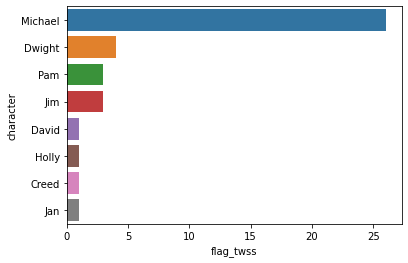

In [67]:
sns.barplot(x="flag_twss", y="character", data=office_twss_character)

In [68]:
office_twss_episode = pd.DataFrame(office.groupby(['season', 'episode']).sum()['flag_twss'].sort_values(ascending = False))
office_twss_episode[office_twss_episode.flag_twss > 0]

flag_twss
season episode           
2      2                3
4      12               3
9      24               2
3      18               2
4      11               2
5      6                1
3      10               1
       13               1
       21               1
4      7                1
       13               1
       16               1
5      5                1
       7                1
2      21               1
7      22               1
       16               1
5      17               1
       19               1
7      14               1
       8                1
6      1                1
       4                1
       24               1
       20               1
3      1                1
4      3                1
2      10               1
       6                1
9      5                1
2      17               1
       15               1
       12               1

In [69]:
office.loc[(office.episode == 2) & (office.season == 2)]['episode_name'][1900]

'Sexual Harassment'

#### Odcinek, w którym było najwięcej razy użyte 'That's what she said' ma tytuł Sexual Harassment

In [71]:
office['flag'] = office['flag_dmtip'] + office['flag_attrm']+ office['flag_twss']
office_flag = pd.DataFrame(office.groupby(['season', 'episode', 'imdb_rating']).sum()['flag'].sort_values(ascending = False))
office_flag = office_flag.sort_values(by=['imdb_rating'], ascending=False)

In [72]:
office_flag

flag
season episode imdb_rating      
7      22      9.7             1
9      24      9.7             3
5      14      9.6             2
9      22      9.3             6
7      17      9.3             0
...                          ...
8      22      7.1             0
       21      7.1             0
       8       7.0             0
6      14      6.8             0
8      19      6.7             0

[186 rows x 1 columns]

### Najlepiej oceniane odcinki to takie, w których występują najbardziej rozpoznawalne "teksty": "That's what she said", "Dunder Mifflin, this is Pam", "Assistant to the regional manager"